# Exploring Ensemble Methods: Boosting Decision Trees

In this notebook we use the pre-implemented gradient boosted trees in Turi Create. 

Among other things, we:
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the _LendingClub_ dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Explore how the number of trees in the ensemble influences performance.

In [2]:
import turicreate

### Load LendingClub dataset

AS we have done in the previous three notebooks, we will be using the [LendingClub](https://www.lendingclub.com/) data. The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

In [3]:
loans = turicreate.SFrame('../data/lending-club-data.sframe/')

In [5]:
loans

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade
1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2
1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4
1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5
1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1
1075269,1311441,5000,5000,5000,36 months,7.9,156.46,A,A4
1072053,1288686,3000,3000,3000,36 months,18.64,109.43,E,E1
1071795,1306957,5600,5600,5600,60 months,21.28,152.39,F,F2
1071570,1306721,5375,5375,5350,60 months,12.69,121.45,B,B5
1070078,1305201,6500,6500,6500,60 months,14.65,153.45,C,C3
1069908,1305008,12000,12000,12000,36 months,12.69,402.54,B,B5


### Create our Target column: `safe_loans`

In [6]:
# We convert the bad_loans data into values that are coherent with our application.

loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

### Selecting features

In this assignment we will only use a subset of categorical and numeric features from the original dataset, described in the code comments below. 

For more detail on the features, see the [LendingClub](https://www.lendingclub.com/)

In [10]:
# Name of target column
target = 'safe_loans'

# Array of feature column names
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

### Dealing with Missing Values

The simplest and most common approach to coping with missing values is to **skip** observations that contain missing values, which is what we will do in this case:

In [9]:
# Remove and separate rows with missing values into another dataset
loans, loans_with_na = loans[[target] + features].dropna_split()

# Count the number of rows with missing data
num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()
print(f'Dropping {num_rows_with_na} observations; keeping {num_rows}')



Dropping 0 observations; keeping 122578


Fortunately there are only 29 rows with NA values in the original dataset, so we retain the bulk of the data.

### Balancing Class Distribution

We have seen in previous notebooks that the dataset has an unbalanced class distribution: most rows are "safe" loans.

In order to balance out our dataset, we will undersample the larger class (safe loans) . Use `seed=1` get the same results.

In [11]:
# Split rows by their class
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Sample safe loans by the ratio of risky to safe loans
percentage = len(risky_loans_raw) / float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)

# We do not undersample risky loans
risky_loans = risky_loans_raw

# Merge both samples into a single dataframe
loans_data = risky_loans.append(safe_loans)

print("Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data)))
print("Percentage of risky loans                :", len(risky_loans) / float(len(loans_data)))
print("Total number of loans in our new dataset :", len(loans_data))

Percentage of safe loans                 : 0.5022471668494506
Percentage of risky loans                : 0.4977528331505494
Total number of loans in our new dataset : 46503


We should now see that the dataset is balanced (approximately 50-50 safe vs risky loans).

### Training and validation split

We split the data into training data and validation data. We used `seed=1` to make sure everyone gets the same results. We will use the validation data to help us select model parameters.

In [12]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

# Gradient boosted tree classifier (from Turi Create)

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** If you are interested in gradient boosted trees, here is some additional reading material:
* [Turi Create user guide](https://apple.github.io/turicreate/docs/api/generated/turicreate.boosted_trees_classifier.BoostedTreesClassifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)

_Gradient boosting is a machine learning technique for regression, classification and other tasks, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.[1][2] When a decision tree is the weak learner, the resulting algorithm is called gradient boosted trees, which usually outperforms random forest.[1][2][3] It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function._


We will now train multiple models to predict `safe_loans` using the features above. In this section, we will experiment with training an **ensemble of 5 trees**. We limit the ensemble classifier at 5 trees when we call the function with `max_iterations=5`.

In [17]:
model_5 = turicreate.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 5)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training Accuracy | Training Log Loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.054713     | 0.657541          | 0.657139          |

| 2         | 0.102548     | 0.656976          | 0.636157          |

| 3         | 0.150918     | 0.664983          | 0.623206          |

| 4         | 0.200747     | 0.668476          | 0.613783          |

| 5         | 0.252508     | 0.673339          | 0.606229          |

+-----------+--------------+-------------------+-------------------+

# Making predictions

As an example we consider a few positive and negative examples from `validation_data`.

In [15]:
# Select all positive and negative examples from the validation set
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select just 2 examples from each class 
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single, 4-row dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float

Rows: 4

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   B   |      0.2      |     0     |       3        |    MORTGAGE    |
|     1      |   B   |      0.6      |     1     |       1        |      RENT      |
|     -1     |   D   |      0.4      |     0     |       3        |      RENT      |
|     -1     |   A   |      1.0      |     0     |       11       |    MORTGAGE    |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 29.44 |    credit_card     |      6.30496      |      0      |        1         |
| 12.19 |    credit_card     |      13.4952      |      0      |        1         |
| 13.97 |       other        |      2.96736      |      3      |        0         |
| 16.33 | debt_consolidation |      1.90524      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        1         |           1           |    8     |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    17    |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    93.9    |        0.0         |   9.91   | ... |
|      1       |    59.1    |        0.0         |  11.71   | ... |
|      1       |    59.5    |        0.0         |  16.77   | ... |
|      1       |    62.1    |        0.0         |   8.9    | ... |
+--------------+------------+--------------------+----------+-----+
[4 rows x 25 columns]

### Predicting on sample validation data

For each row in the **sample_validation_data**, write code to make **model_5** predict whether or not the loan is classified as a **safe loan**.

**Hint:** Use the `predict` method in `model_5` for this.

In [18]:
for i in range(len(sample_validation_data)):
    obs = sample_validation_data[i]
    pred = model_5.predict(obs)
    print(f"Observation {i+1} prediction = {pred}, expected = {obs[target]}")

Observation 1 prediction = [1], expected = 1
Observation 2 prediction = [1], expected = 1
Observation 3 prediction = [-1], expected = -1
Observation 4 prediction = [1], expected = -1


**Quiz Question:** What percentage of the predictions on `sample_validation_data` did `model_5` get correct? 
`A = 0.75`


### Prediction probabilities

For each row in the `sample_validation_data`, what is the probability (according to our `model_5`) of a loan being classified as **safe** (+1)? 

For this task we can set `output_type='probability'` to make **probability** predictions using `model_5` on `sample_validation_data`:

In [20]:
for i in range(len(sample_validation_data)):
    obs = sample_validation_data[i]
    pred = model_5.predict(obs)
    prob = model_5.predict(obs, output_type='probability')
    print(f"Observation {i+1} prediction probability of (+1) = {prob}, predicted = {pred}")

Observation 1 prediction probability of (+1) = [0.7045905590057373], predicted = [1]
Observation 2 prediction probability of (+1) = [0.5963408946990967], predicted = [1]
Observation 3 prediction probability of (+1) = [0.44925159215927124], predicted = [-1]
Observation 4 prediction probability of (+1) = [0.6119099855422974], predicted = [1]


**Quiz Question:** According to **model_5**, which loan is the least likely to be a safe loan?
`A = loan 1`

## Evaluating the model on Validation Set

Accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Turi create implements conveniently a method on the tree model for us for this task: `.evaluate()`.

In [22]:
model_5.evaluate(validation_data)
# 0.66813873330461

{'accuracy': 0.66813873330461,
 'auc': 0.7246842336920359,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      -1      |        1        |  1618 |
 |      -1      |        -1       |  3054 |
 |      1       |        -1       |  1463 |
 |      1       |        1        |  3149 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6715001599317625,
 'log_loss': 0.6176131769693981,
 'precision': 0.6605831760016782,
 'recall': 0.6827840416305291,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 4612 | 4672 |
 |   0.001   | 1.0 | 1.0 | 4612 | 4672 |
 |   0.002   | 1.0 | 1.

Calculate the number of **false positives** made by the model.

In [28]:
fp=0
fn=0

for row in validation_data:
    prediction = (model_5.predict(row))[0]
    
    if row[target] == -1 and prediction == +1:
        fp += 1
    
    if row[target] == +1 and prediction == -1:
        fn += 1

In [29]:
print("False positives", fp)
print("False negatives", fn)

False positives 1618
False negatives 1463


**Quiz Question**: What is the number of **false positives** on the **validation_data**?
`A = 1618`

What is the number of **false negatives** made by the model?
`A = 1463`

## Comparison with decision trees

Ina previous notebook, using the same validation set we obtained a prediction accuracy of the decision trees around **0.64** (rounded). With gradient boosted trees, we saw that **model_5** has an accuracy of **0.67** (rounded).

We can quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment, by calculating a simulated cost of mistakes.

Consider the following costs (same as last notebook):

* For every **False negative**:  \$10,000 
* For every **False positive**:  \$20,000 

Assuming that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

We can then calculate the total cost of the mistakes made by the non-boosted decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost is $49.42M. That is a **lot of money**!.

**Quiz Question**: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**?
`A = 46.9M`

In [31]:
cost = 10000 * fn + 20000 * fp
print("Total cost: $", cost)

Total cost: $ 46990000


**Reminder**: The extra 3% improvement in prediction accuracy can translate to several million dollars!  And, it was so easy to get by simply boosting our decision trees.

## Bonus: Most positive & negative loans.

In this section, we find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**. Add the probability predictions as a column called **predictions** into the validation_data. Finally we sort the data in descreasing order by probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. Use `output_type = probability`.

In [33]:
N = len(validation_data)
pp = [0.0 for _ in range(N)]

for i in range(N):
    pp[i] = model_5.predict(validation_data[i], output_type='probability')[0]

pp

[0.44925159215927124,
 0.6119099855422974,
 0.38359811902046204,
 0.3693307042121887,
 0.5947023034095764,
 0.33775463700294495,
 0.5894419550895691,
 0.5446626543998718,
 0.3429364860057831,
 0.41004064679145813,
 0.2832150459289551,
 0.5691449642181396,
 0.46964702010154724,
 0.3429364860057831,
 0.6144581437110901,
 0.554015040397644,
 0.5142186880111694,
 0.5819669365882874,
 0.3220672011375427,
 0.3770946264266968,
 0.475700318813324,
 0.6697177290916443,
 0.5418840050697327,
 0.5071180462837219,
 0.41004064679145813,
 0.5227286219596863,
 0.17995232343673706,
 0.5045105218887329,
 0.5033908486366272,
 0.479425847530365,
 0.41979292035102844,
 0.5254865884780884,
 0.5815758109092712,
 0.4266439974308014,
 0.6009397506713867,
 0.45297345519065857,
 0.5968388319015503,
 0.40791797637939453,
 0.712032675743103,
 0.4963512420654297,
 0.4210338592529297,
 0.5146543979644775,
 0.4462275207042694,
 0.7797378897666931,
 0.4468776285648346,
 0.20691286027431488,
 0.6439365744590759,
 0.476

In [34]:
validation_data['predictions'] = pp

Now, we are ready to go to **Step 3**. You can now use the `prediction` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [39]:
most_safe_loans = validation_data.sort('predictions', ascending=False)

In [41]:
most_safe_loans[:5]

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float
	predictions	float

Rows: 5

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   A   |      0.2      |     0     |       11       |    MORTGAGE    |
|     1      |   A   |      0.4      |     0     |       4        |    MORTGAGE    |
|     1      |   A   |      0.6      |     0     |       11       |    MORTGAGE    |
|     1      |   A   |      0.2      |     0     |       11       |    MORTGAGE    |
|     1      |   A   |      0.2      |     0     |       11       |      OWN       |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+----------------+-------------------+-------------+------------------+
|  dti  |    purpose     | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+----------------+-------------------+-------------+------------------+
|  4.21 |  credit_card   |      0.955726     |      0      |        1         |
| 12.76 |      car       |       1.7376      |      0      |        1         |
|  2.4  |      car       |      2.49545      |      0      |        1         |
|  6.47 | major_purchase |       1.131       |      1      |        0         |
|  0.69 |      car       |      3.17372      |      0      |        1         |
+-------+----------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       2        |        1         |           1           |    9     |    0    |
|       2        |        1         |           1           |    11    |    0    |
|       0        |        1         |           1           |    6     |    0    |
|       0        |        0         |           1           |    9     |    0    |
|       0        |        1         |           1           |    4     |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    7.9     |        0.0         |   6.39   | ... |
|      1       |    5.5     |        0.0         |   6.76   | ... |
|      1       |    0.0     |        0.0         |   6.17   | ... |
|      1       |    9.6     |        0.0         |   5.42   | ... |
|      1       |    9.1     |        0.0         |   6.03   | ... |
+--------------+------------+--------------------+----------+-----+
[5 rows x 26 columns]

**Quiz Question**: What grades are the top 5 loans?
`A = A`


In [46]:
# Let us repeat this excercise to find the 5 loans with the **lowest probability** of being predicted as a **safe loan**:
most_safe_loans[N-5:]

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float
	predictions	float

Rows: 5

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     -1     |   B   |      1.0      |     0     |       5        |      RENT      |
|     -1     |   C   |      0.4      |     0     |       4        |      RENT      |
|     -1     |   D   |      0.8      |     0     |       3        |      RENT      |
|     -1     |   C   |      0.8      |     1     |       0        |    MORTGAGE    |
|     -1     |   C   |      0.2      |     0     |       5        |      RENT      |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 29.42 | debt_consolidation |      14.3733      |      0      |        1         |
|  8.4  |    credit_card     |      11.8779      |      0      |        1         |
|  8.95 |   small_business   |       16.727      |      0      |        1         |
| 17.37 |  home_improvement  |      12.5753      |      0      |        1         |
| 30.17 | debt_consolidation |      13.5391      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    9     |    0    |
|       2        |        1         |           1           |    7     |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       1        |        1         |           1           |    7     |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    57.5    |      20.9132       |  14.09   | ... |
|      1       |    60.0    |       34.64        |  15.31   | ... |
|      1       |    41.6    |      16.7025       |   15.2   | ... |
|      1       |    46.1    |       18.86        |  15.31   | ... |
|      1       |    80.7    |      19.7362       |  14.33   | ... |
+--------------+------------+--------------------+----------+-----+
[5 rows x 26 columns]

## Effect of adding more trees

In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module. 

Let's get sarted with a model with **max_iterations = 10**:

In [47]:
model_10 = turicreate.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 10, verbose=False)

Now, train 4 models with **max_iterations** to be:
* `max_iterations = 50`, 
* `max_iterations = 100`
* `max_iterations = 200`
* `max_iterations = 500`. 

Let us call these models **model_50**, **model_100**, **model_200**, and **model_500**. You can pass in `verbose=False` in order to suppress the printed output.

**Warning:** This could take a couple of minutes to run.

In [48]:
model_50 = turicreate.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 50, verbose=False)
model_100 = turicreate.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 100, verbose=False)
model_200 = turicreate.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 200, verbose=False)
model_500 = turicreate.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 500, verbose=False)

## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**. Use the `.evaluate` method.

In [50]:
acc_50 = model_50.evaluate(validation_data)['accuracy']
acc_100 = model_100.evaluate(validation_data)['accuracy']
acc_200 = model_200.evaluate(validation_data)['accuracy']
acc_500 = model_500.evaluate(validation_data)['accuracy']

In [51]:
print("50", acc_50)
print("100", acc_100),
print("200", acc_200),
print("500", acc_500)

50 0.6907582938388626
100 0.6917277035760449
200 0.684510986643688
500 0.6718009478672986


**Quiz Question:** Which model has the **best** accuracy on the **validation_data**? `A = 50`

**Quiz Question:** Is it always true that the model with the most trees will perform best on test data? `A = No because of overfitting`

### Plotting the training and validation error vs. number of trees

Classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

We will plot the **training and validation errors vs. number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need [matplotlib](http://matplotlib.org/downloads.html) in order to visualize the plots. 

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [56]:
models = [model_10, model_50, model_100, model_200, model_500]

training_errors = [0.0 for _ in range(5)]
validation_errors = [0.0 for _ in range(5)]

for i in range(5):
    m = models[i]
    training_errors[i] = 1 - m.evaluate(train_data)['accuracy'] 
    validation_errors[i] = 1 - m.evaluate(validation_data)['accuracy']

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

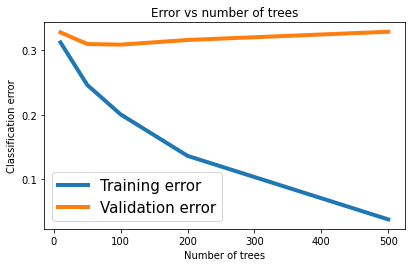

In [57]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

**Quiz Question**: Does the training error reduce as the number of trees increases? `A = yes`

**Quiz Question**: Is it always true that the validation error will reduce as the number of trees increases? `A = no`